# Intervention analysis with hierarchical models

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">

This notebook is an element of the free [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/). 

Author: Eric Marsden <eric.marsden@risk-engineering.org>. 

---

This notebook contains an introduction to use of Python and the NumPy and Pandas libraries for the analysis of data using a hierarchical model. 
See the [associated course materials](https://risk-engineering.org/statistical-modelling/) for background information and to download this content as a Jupyter notebook.

## Introduction

We are going to analyze a dataset that provides the dates of 191 explosions in coal mines in the UK that resulted in 10 or more fatalities. The data spans from 1851 to 1962 and the source is article 

R. G. Jarrett. A note on the intervals between coal mining disasters. Biometrika, 66:191–193, 1979, DOI: [10.1093/biomet/66.1.191](https://doi.org/10.1093/biomet/66.1.191), also available [without a paywall](http://www.dima.unige.it/~riccomag/Teaching/ProcessiStocastici/coal-mining-disaster-original%20paper.pdf). 

Coal mining has long held a dreadful record for both safety and for health at work, with large numbers of fatal accidents, brutality in work relations, high rates of lung diseases, long hours and highly dangerous and adverse working conditions. 

There appears to be a trend changepoint in the data around 1895, where the rate of accidents decreases. We are going to try to determine whether there is indeed a change in the rate before and after the changepoint, and whether we can identify the changepoint date automatically.  

This is an area of statistical analysis called “intervention analysis”, the application of modeling procedures for incorporating the effects of an intervention (a change to a procedure, law, or policy, or some other exogenous force) in time series analysis. The techniques are also called [interrupted time series analysis](https://en.wikipedia.org/wiki/Interrupted_time_series) and [change detection](https://en.wikipedia.org/wiki/Change_detection). In this application, we want to determine whether new safety procedures introduced in the mining industry were effective (did they lead to a reduction in the number of accidents?).

In [4]:
import numpy
import scipy.stats
import pandas
import matplotlib.pyplot as plt
plt.style.use("bmh")

## Data cleanup

The first step in any data analysis project is obtaining the data in a useable format, and cleaning it up. This somewhat unsexy work is often reported to be a significant part of the job of data scientists in industry. In this case, the dataset we want to analyze has been quite widely used and checked by statisticians and is used for teaching exercises. It’s conveniently [available in the R package `boot`](https://stat.ethz.ch/R-manual/R-devel/library/boot/html/coal.html). 

We can read the compressed RData files using a Python library called `pyreadr`, which you will probably have to install using a command such as 

   > sudo pip3 install pyreadr

In [7]:
import pyreadr
import requests
import tempfile
import os

# download the data to a temporary file that can be read by the pyreadr 
# library, then delete the temporary file
data = requests.get("https://github.com/cran/boot/raw/master/data/coal.rda")
tmp = tempfile.NamedTemporaryFile(delete=False)
tmp.write(data.content)
tmp.close()
rda = pyreadr.read_r(tmp.name)
os.unlink(tmp.name)

rda.keys()

odict_keys(['coal'])

In [8]:
# how many entries do we have?
len(rda["coal"])

191

In [9]:
rda["coal"].head()

date
rownames             
1         1851.202601
2         1851.632444
3         1851.969199
4         1851.974675
5         1852.314168

This dataset is encoded in a slightly strange manner, as explained in the [R documentation for the package](https://stat.ethz.ch/R-manual/R-devel/library/boot/html/coal.html): 
    
> The integer part of date gives the year. The day is represented as the 
> fraction of the year that had elapsed on that day. 

To use builtin Pandas filtering functionality, we’re going to have to convert these dates to the Python `datetime` representation.

In [11]:
import datetime
import arrow
import math

def convert_rdate(funnydate) -> datetime.datetime:
    year = math.floor(funnydate)
    days = 365 * (funnydate - year)
    when =  arrow.Arrow(year, 1, 1)
    return when.shift(days= +days).naive

# a little testing
convert_rdate(1851.5)

datetime.datetime(1851, 7, 2, 12, 0)

In [12]:
accidents = rda["coal"]
accidents["datetime"] = accidents["date"].apply(convert_rdate)
accidents.head()

date                   datetime
rownames                                        
1         1851.202601 1851-03-15 22:47:03.819302
2         1851.632444 1851-08-19 20:12:19.219710
3         1851.969199 1851-12-20 18:11:05.297738
4         1851.974675 1851-12-22 18:09:07.022587
5         1852.314168 1852-04-24 16:06:53.963036

## Exploratory data analysis

We are going to explore our dataset a little to get a feeling for whether it looks plausible, before undertaking any detailed analysis. First of all, what is the period covered by our observations?

In [15]:
accidents.datetime.min(), accidents.datetime.max()

(Timestamp('1851-03-15 22:47:03.819302'),
 Timestamp('1962-03-22 04:40:54.209445'))

Let’s try to plot our data to get a feel for the distribution of accidents. We plot the number of accidents over time, by binning per year.

In [17]:
year_ts = accidents.datetime.apply(lambda ts: ts.year)
year_ts.head()

rownames
1    1851
2    1851
3    1851
4    1851
5    1852
Name: datetime, dtype: int64

In [18]:
accident_years, counts = numpy.unique(year_ts, return_counts=True)

In [19]:
accident_years

array([1851, 1852, 1853, 1854, 1856, 1857, 1858, 1860, 1861, 1862, 1863,
       1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875,
       1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886,
       1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1899,
       1901, 1902, 1905, 1906, 1908, 1909, 1910, 1912, 1913, 1914, 1916,
       1918, 1922, 1923, 1927, 1928, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1946, 1947, 1951, 1957,
       1960, 1962], dtype=int64)

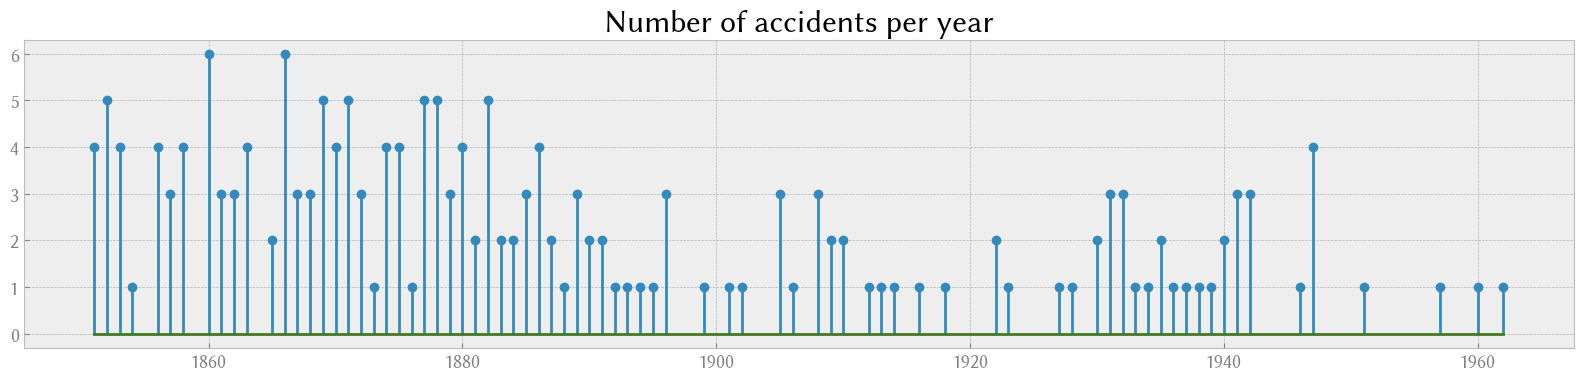

In [20]:
plt.figure().set_size_inches(20, 4)
plt.stem(accident_years, counts)
plt.title("Number of accidents per year");

## Trend data

The plot of the number of accidents per year is a little “noisy”; there is too much variation from year to year to get a feel for a trend. We can try various methods to obtain a “smoother” trend line for the accident rate. We’ll start by using some builtin Pandas functionality for resampling on time series and grouping per time period. To use it, we need to index our dataframe by the `datetime` column, rather than by a generated sequence number. 

In [23]:
accidents_ts = accidents.set_index("datetime")
accidents_ts.drop(columns=["date"], inplace=True)
accidents_ts["count"] = 1
accidents_ts.head()

count
datetime                         
1851-03-15 22:47:03.819302      1
1851-08-19 20:12:19.219710      1
1851-12-20 18:11:05.297738      1
1851-12-22 18:09:07.022587      1
1852-04-24 16:06:53.963036      1

Now we can [resample](https://pandas.pydata.org/docs/reference/resampling.html) the data over whatever time period we are interested in, starting by yearly. 

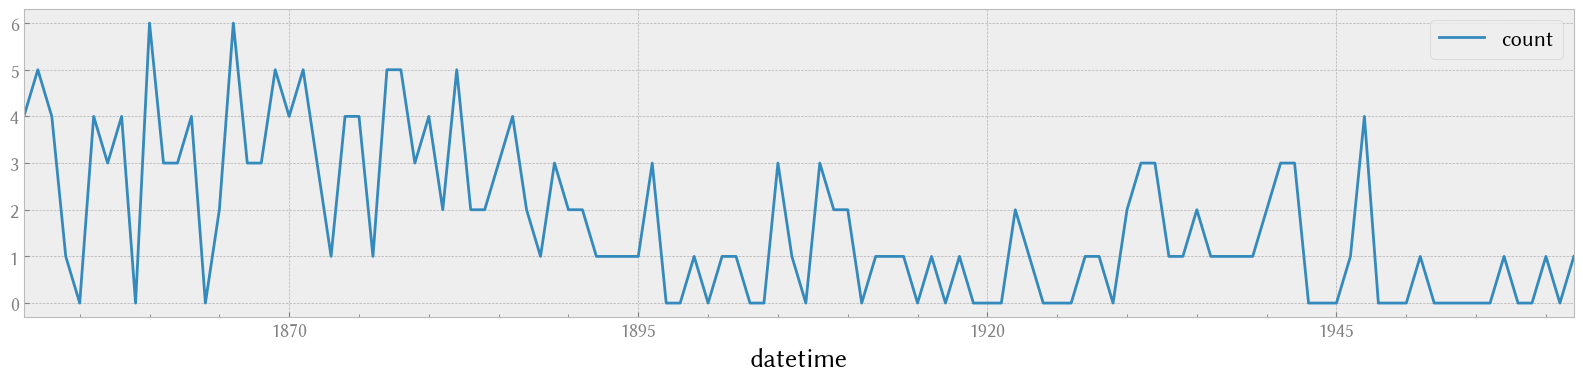

In [25]:
accidents_yearly = accidents_ts.resample("YE").count()
accidents_yearly.interpolate(method="spline", order=3).plot(figsize=(20,4));

There is too much variation in the number per year. Let’s try different approaches to obtain a “smoother” trend line, firstly by using larger “buckets” in our resampling. 

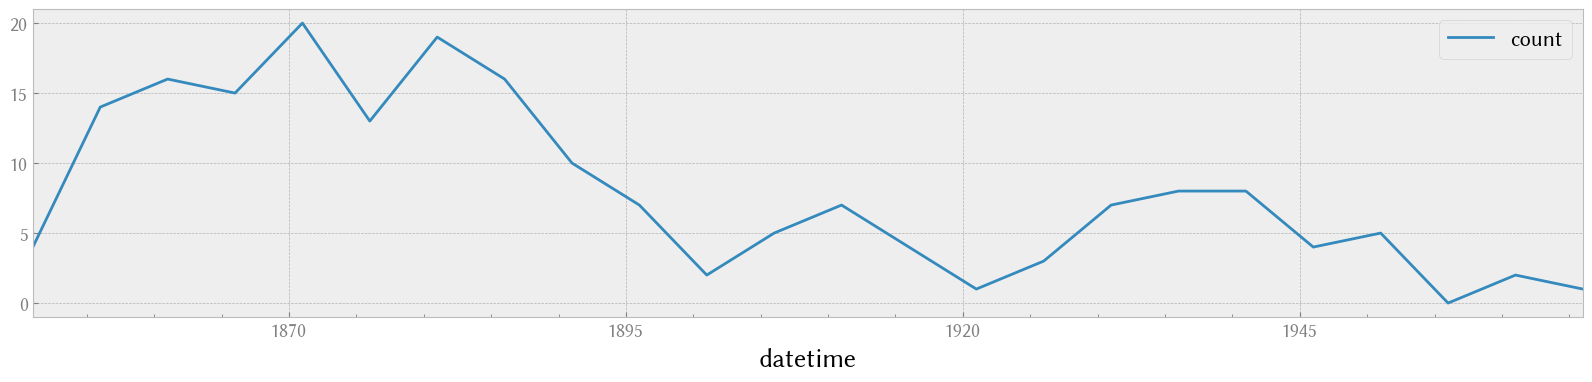

In [27]:
# buckets of size 5 years
per_period = accidents_ts.resample("5YE").count()
per_period.plot(figsize=(20,4));

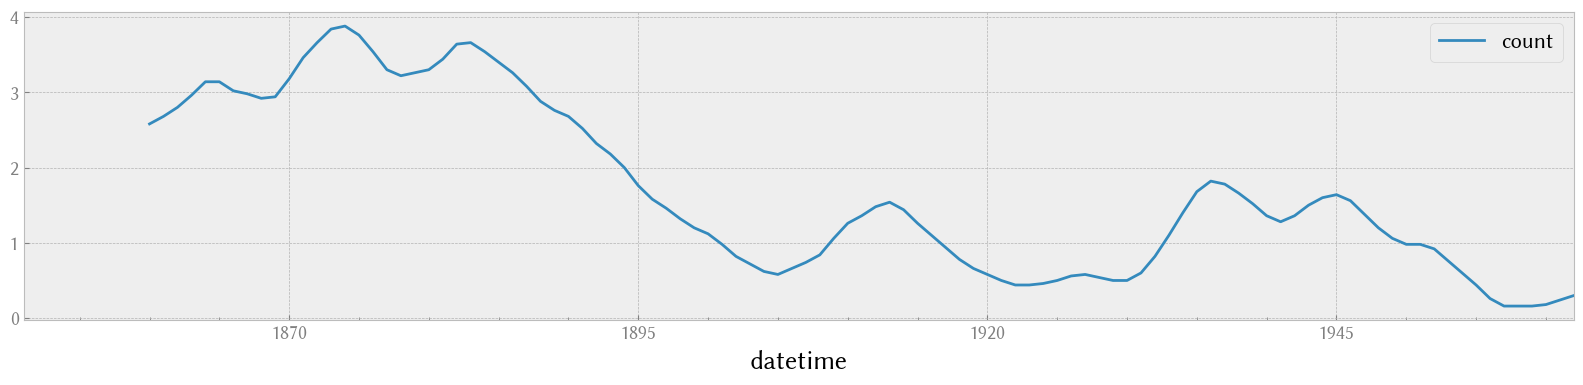

In [28]:
# try rolling mean
rolling = accidents_yearly.rolling(10, win_type="triang").mean()
rolling.plot(figsize=(20,4));

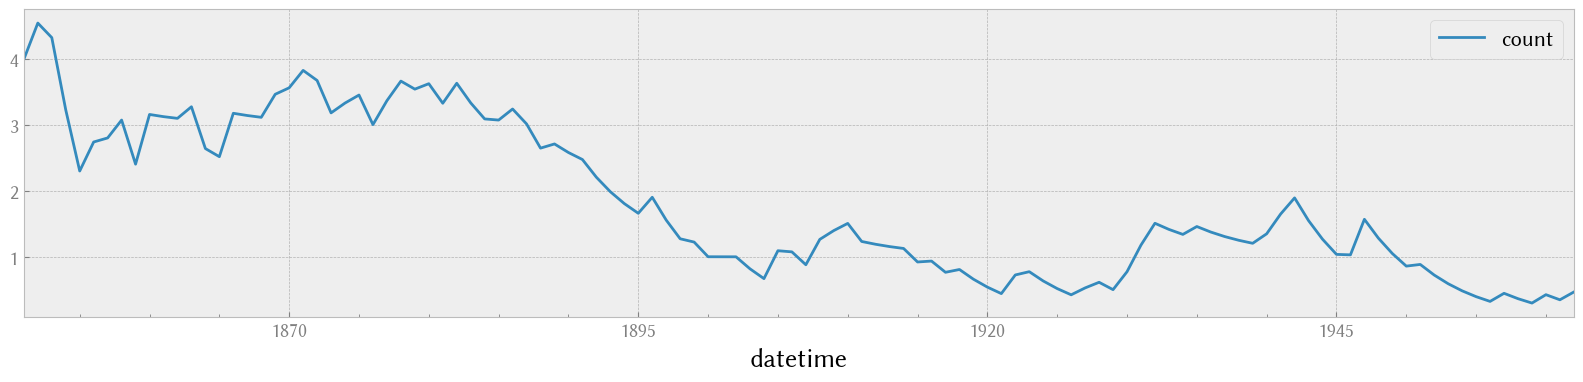

In [29]:
# exponentially weighted moving average
ew = pandas.Series.ewm(accidents_yearly, span=10).mean()
ew.plot(figsize=(20,4));

## Check hypothesis that events are independent

If we assume that these accidents are independent and occur randomly at a constant average rate, their occurrence should follow a Poisson process. This means that the number of accidents per year should follow a Poisson distribution. Let’s check whether this assumption seems reasonable. 

We are going to analyze the data before 1895, to avoid the impact of the change in trend a little after that date. 

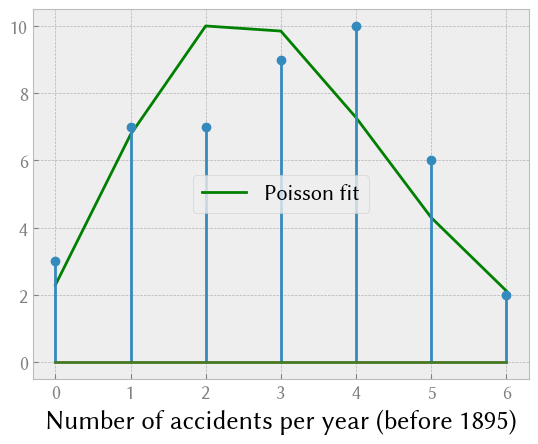

In [32]:
# plot a histogram of the number of accidents per year, for years before 1895,
# and superimpose a Poisson fit
accidents_before = accidents_yearly.loc[:"1895-01-01"]
x, y = numpy.unique(accidents_before, return_counts=True)
rate = accidents_before.mean()
observations = y.sum()
plt.plot(x, observations * scipy.stats.poisson(rate).pmf(x), label="Poisson fit", color="g")
plt.stem(x, y)
plt.xlabel("Number of accidents per year (before 1895)")
plt.legend();

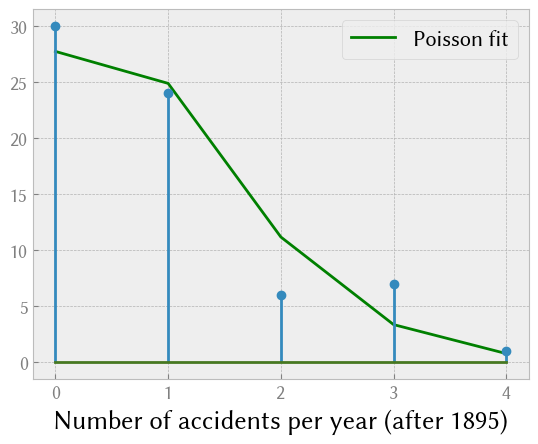

In [33]:
# accidents after 1900 with a Poisson fit
accidents_after = accidents_yearly.loc["1895-01-01":]
x, y = numpy.unique(accidents_after, return_counts=True)
rate = accidents_after.mean()
observations = y.sum()
plt.plot(x, observations * scipy.stats.poisson(rate).pmf(x), label="Poisson fit", color="g")
plt.stem(x, y)
plt.xlabel("Number of accidents per year (after 1895)")
plt.legend();

This fits reasonably well, which means our hypothesis of independent events is plausible. As a further check, given that the accidents seem to follow a Poisson process, the **time between successive accidents** should follow an **exponential** distribution.

In [35]:
before = accidents.datetime[accidents.datetime < datetime.datetime(1895, 1, 1)]
len(before)

130

In [36]:
# fit an exponential distribution to this timeseries to determine Poisson rate
duration = before.max() - before.min()
density = len(before) / float(duration.days)
density  # events per day

0.008224724788055169

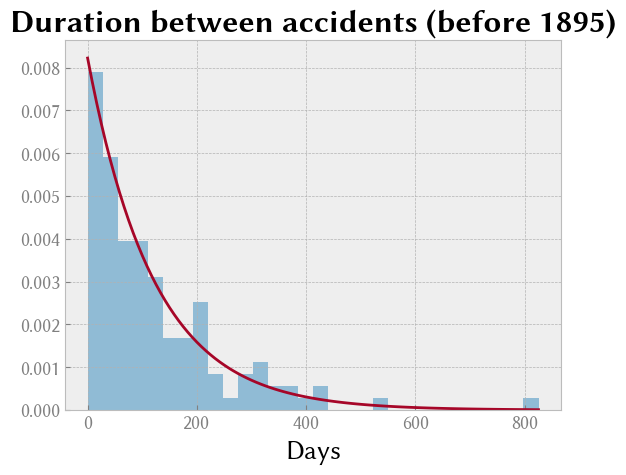

In [37]:
# calculate the time delta between successive rows and convert into days
interarrival = before.diff().dropna().apply(lambda x: x / numpy.timedelta64(1, "D"))
support = numpy.linspace(interarrival.min(), interarrival.max(), 100)
interarrival.hist(density=True, alpha=0.5, bins=30)
plt.plot(support, scipy.stats.expon(scale=1/density).pdf(support), lw=2)
plt.title("Duration between accidents (before 1895)", weight="bold")
plt.xlabel("Days");

It seems plausible that occurrences of disasters in the time series follow a Poisson process with a large rate parameter in the early part of the time series, and one with a smaller rate in the later part. Let's check that idea. 

In [39]:
# yearly rate before 1900
accidents_yearly.loc[:"1900-01-01"].mean()

count    2.755102
dtype: float64

In [40]:
# yearly rate after 1900
accidents_yearly.loc["1900-01-01":].mean()

count    0.888889
dtype: float64

Indeed, the rate before and after 1900 is very different!

We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations. We can try to find this tend changepoint automatically.

## Finding switchover date

We define a function that measures the “badness of fit” between a dataset (our observations) and a probability distribution (our mathematical model). A classical measure for badness of fit is the [root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation), which is the sum of the squared deviations between our observations and the model, raised to the power one half. 

In [44]:
# root mean squared error
def RMSE(data, distribution) -> float:
    # group the interarrival times into bins
    interarrival = data.diff().dropna().apply(lambda x: x / numpy.timedelta64(1, "D"))
    (values, bins) = numpy.histogram(interarrival)
    accum = 0
    for i in range(len(bins)-1):
        accum += (values[i] - distribution((bins[i] + bins[i+1])/2.0))**2
    return numpy.sqrt(accum)

With the RMSE, we can calculate the badness of fit for our two-segment model, where we are fitting one Poisson distribution to the events before the switchover date and another Poisson distribution to events after the switchover date. In fact, we are examining the time between successive events, so we are fitting two exponential distributions. 

In [46]:
# measure badness of fit for our two-segment model
def badness_measure(data, switchover: datetime) -> float:
    before = data.datetime[data.datetime < switchover]    
    before_duration = before.max() - before.min()
    before_density = len(before) / float(before_duration.days)
    after = data.datetime[data.datetime >= switchover]
    after_duration = after.max() - after.min()
    after_density = len(after) / float(after_duration.days)
    return RMSE(before, scipy.stats.expon(1/before_density).pdf) + \
           RMSE(after, scipy.stats.expon(1/after_density).pdf)

In [47]:
badness_measure(accidents, datetime.datetime(1900, 1, 1))

120.39574619665044

To determine the trendpoint change, we will plot our badness measure for different choices of the switchover point between 1860 and 1940. The trendpoint change will be located at the point where badness is lowest. 

In [49]:
support = numpy.linspace(1860, 1940, 50)
badness = [badness_measure(accidents, datetime.datetime(math.floor(y), 1, 1)) for y in support]

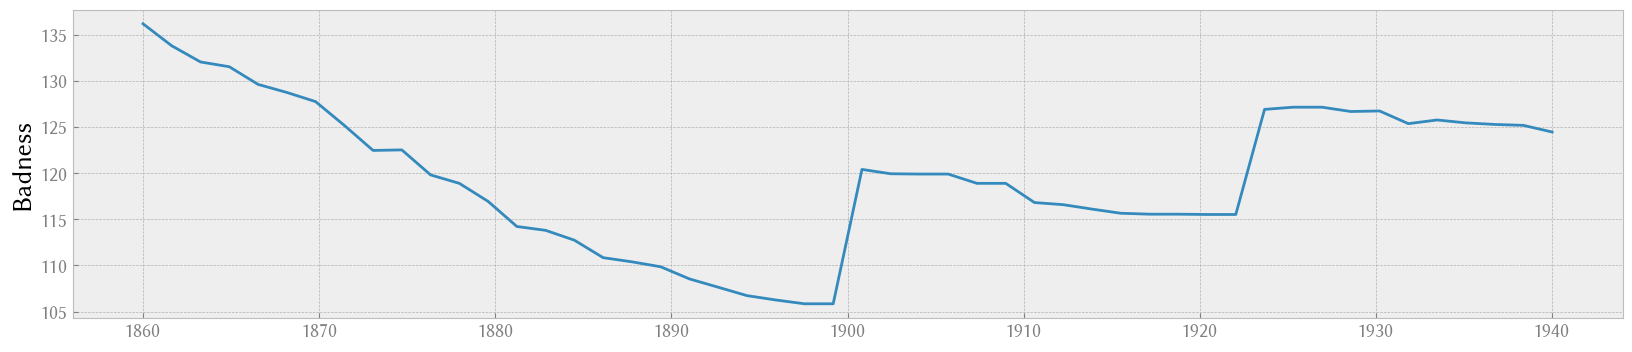

In [50]:
plt.figure().set_size_inches(20, 4)
plt.plot(support, badness)
plt.ylabel("Badness");

From this graph, we see that the trend changepoint is located somewhere around year 1897. 

Now let’s see whether we can correlate this changepoint with a specific regulatory or operational change in the coal mines, as a form of ex post validation of the effectiveness of the change. There were a large number of [historical changes](http://www.dmm.org.uk/pitwork/html/deaths.htm) to safety regulations in coal mines in the UK over the period we are discussing, the most significant being:

- 1834: obligation to use a cage to transport miners underground

- 1850: creation of government inspectors, mine owners must maintain plans of each mine, and notify fatal accidents to the Secretary of State responsible for inspectors

- 1860: various technical requirements on issues such as underground transport systems, precautions against inrushes of wet material, fencing off dangerous places, locking and care of flame safety lamps

- 1862: a minimum of two shafts required for any coal mine

- 1872: the Coal Mines Regulation Act 

- 1886: Coal Mines Act provides powers for formal investigation

- 1887: inspection of pits by workmen

- 1896: Coal Mines Regulation Act aimed at preventing explosions, especially from coal dust

- 1911: Coal Mines Act with regulations and orders relating to safety and health

Naturally, a new law passed in Parliament does not immediately lead to operational changes at the front line (at the coal face, in this case). If we examine the progressive downward trend in accident rate visible between 1880 and 1900, it seems plausible that the 1872, 1887 and 1896 laws had an effect on safety (it is also possible that the trend is explained by other factors, such as raising awareness of safety issues by coal mine owners, but we don’t have the information needed to determine this). 

## Going further

- We assumed that this data contained a single change point. In theory there might be multiple change points, and the method used in this notebook could be generalized to estimate them. 
  
- Our implementation of a goodness of fit measure to find the change point was a little ad hoc. This type of problem is well suited to Bayesian analysis. Check out a [worked example using the `pymc3` library in Python](https://github.com/pymc-devs/pymc-examples/blob/main/examples/case_studies/disaster_model.py)

- There are libraries in Python that implement more sophisticated techniques for this type of analysis and forecasting, such as [Facebook's prophet library](https://facebook.github.io/prophet/), which has [support for automatic changepoint detection](https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet).

- EdX offer a free online short course [Policy Analysis Using Interrupted Time Series](https://www.edx.org/course/policy-analysis-using-interrupted-time-series). 